# Workshop Tutorial: Features (Spots & Gaussian Processes)

In this tutorial we'll learn how to add spots on a star and gaussian processes to a light curve.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:
* [Features](http://phoebe-project.org/docs/latest/tutorials/features.ipynb)
* [Advanced: Spots](http://phoebe-project.org/docs/latest/tutorials/spots.ipynb)
* [Example: Gaussian Processes](http://phoebe-project.org/docs/latest/examples/minimal_GPs)

# Setup

In [1]:
import phoebe
from phoebe import u,c

In [2]:
logger = phoebe.logger(clevel='WARNING')

In [3]:
b = phoebe.default_binary()

# Spots

Multiple [spot features](http://phoebe-project.org/docs/2.4/api/phoebe.parameters.feature.spot.md) can be attached to any given Star in the system.  Because of this, they live in the "feature" context (along with future features such as pulsations).  Adding a spot follows the same syntax as datasets or compute options:

In [4]:
b.add_feature('spot', component='primary', feature='spot01')

<ParameterSet: 5 parameters | contexts: feature, compute>

In [5]:
print(b.filter(feature='spot01'))

ParameterSet: 5 parameters
             colat@spot01@feature: 0.0 deg
              long@spot01@feature: 0.0 deg
            radius@spot01@feature: 1.0 deg
           relteff@spot01@feature: 1.0
         enabled@phoebe01@compute: True


As a shortcut, you can call [b.add_spot](http://phoebe-project.org/docs/2.4/api/phoebe.frontend.bundle.Bundle.add_spot.md):

In [6]:
b.add_spot(component='secondary', feature='spot02')

<ParameterSet: 5 parameters | contexts: feature, compute>

The spot is parameterized by the colatitude (where 0 is defined as the North (spin) Pole) and longitude (where 0 is defined as pointing towards the other star for a binary, or to the observer for a single star) of its center, its angular radius, and the ratio of temperature of the spot to the local intrinsic value.

# Gaussian Processes

Similarly to spots, multiple gaussian process features an be attached - but instead of being attached to a Star (component), they are attached to a light curve (dataset). As of PHOEBE 2.4, we support two "backends" for Gaussian Processes: [gp_celerite2](http://phoebe-project.org/docs/2.4/api/phoebe.parameters.feature.gp_celerite2) and [gp_sklearn](http://phoebe-project.org/docs/2.4/api/phoebe.parameters.feature.gp_sklearn). We will discuss more about the pros and cons of each one towards the end of the second part of the workshop.

**NOTE**: gaussian processes require [celerite2](https://celerite2.readthedocs.io) and [sklearn](https://scikit-learn.org/stable/index.html) to be installed _before_ importing phoebe (you can install with `pip install celerite2` and `pip install scikit-learn` and may need to restart the kernel/notebook). For the purposes of this tutorial, we'll only use `celerite2`.

In [7]:
b.add_dataset('lc', compute_times=phoebe.linspace(0,1,101), dataset='lc01')

<ParameterSet: 80 parameters | contexts: dataset, compute, figure, constraint>

We can add a gaussian process with either [b.add_feature](http://phoebe-project.org/docs/latest/api/phoebe.frontend.bundle.Bundle.add_feature.md) and passing either 'gp_celerite2' or 'gp_sklearn' as the first argument or [b.add_gaussian_process](http://phoebe-project.org/docs/latest/api/phoebe.frontend.bundle.Bundle.add_gaussian_process.md), and pass 'celerite2' or 'sklearn' as the first argument.

In [8]:
b.add_feature('gp_celerite2', dataset='lc01', feature='gp01')

<ParameterSet: 11 parameters | contexts: feature, compute>

In [9]:
print(b.filter(feature='gp01'))

ParameterSet: 7 parameters
              kernel@gp01@feature: sho
                 rho@gp01@feature: 1.0
                 tau@gp01@feature: 1.0
               sigma@gp01@feature: 1.0
                 eps@gp01@feature: 1e-05
       alg_operation@gp01@feature: sum
    enabled@gp01@phoebe01@compute: True


Gaussian processes do not do anything unless there are observational data attached to the dataset.

In [10]:
print(b.run_checks())

Run Checks Report: FAIL
ERROR: gaussian process requires observational data and sigmas (5 affected parameters, affecting run_compute)


So let's add some observational data that we'll be using in the second week (and cheat for now and set a period that is close to correct), just so that we can see how the model is exposed.

In [11]:
import numpy as np
times, fluxes, sigmas = np.loadtxt('data/synthetic/lc.data', unpack=True)

In [12]:
b.set_value('period', component='binary', value=1.67)
b.add_dataset('lc', times=times, fluxes=fluxes, sigmas=sigmas, dataset='lc01', overwrite=True)

<ParameterSet: 57 parameters | contexts: compute, dataset, feature, figure, constraint>

In [13]:
print(b.run_checks())

Run Checks Report: PASS



In [14]:
b.run_compute(distortion_method='sphere') # overriding the distortion method here to speed up the computation

100%|████████████████████████████████████████| 200/200 [00:04<00:00, 43.49it/s]


<ParameterSet: 5 parameters | qualifiers: gps, comments, fluxes, times, fluxes_nogps>

Now our model contains two new parameters `gps` (the GP component of the fluxes) and `fluxes_nogps` (such that `fluxes = fluxes_nogps + gps`.  

Note that even if `compute_times` or `compute_phases` is provided, the resulting model will be exposed at all underlying dataset times (even though the physical model was compute at `compute_times` and then interpolated onto the dataset times).

In [15]:
print(b.get_model())

ParameterSet: 5 parameters
R              times@latest@model: [0.04695476 0.11714084 0.18521794 ... 9.78618342
 9.88373838 9.98847007] d
R             fluxes@latest@model: [1.52751522 1.52734012 1.51780778 ... 1.52463692
 1.53370349 1.52941448] W / m2
            comments@latest@model: 
R                gps@latest@model: [-0.03641183 -0.48602909 -0.4929114  ... -0.4839793
 -0.4791103   0.16804268] W / m2
R       fluxes_nogps@latest@model: [1.56392705 2.01336921 2.01071918 ...
 2.00861622 2.01281379 1.3613718 ] W / m2


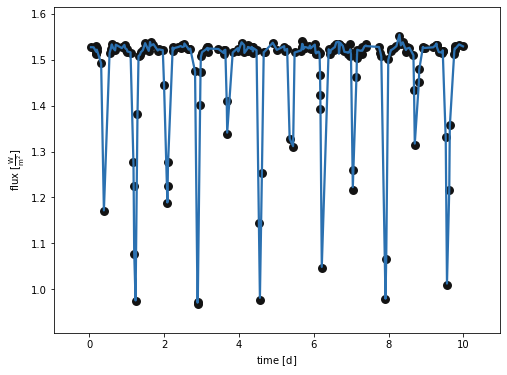

In [16]:
_ = b.plot(show=True)

Thu, 16 Jun 2022 08:25 PARAMETERS   WARNING defaulting to i='times' to plot in time-order because system is time_dependent.  Pass i='phases' to override.
Thu, 16 Jun 2022 08:25 PARAMETERS   WARNING defaulting to i='times' to plot in time-order because system is time_dependent.  Pass i='phases' to override.


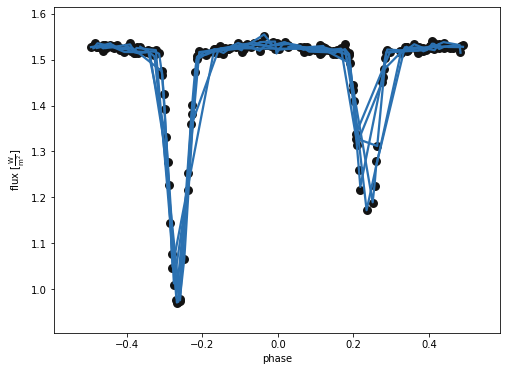

In [17]:
_ = b.plot(x='phases', show=True)

# Exercise

Plot a light curve with and without a spot.

Make a mesh plot that shows the presence of a spot and get comfortable with how the coordinate system is defined.  Try for both binary systems and single stars.

Try creating a synthetic light curve set as in the [Gaussian Process example online](http://phoebe-project.org/docs/latest/examples/minimal_GPs) and play with different kernel and plotting options.